In [3]:
import cv2
import numpy as np
from torchvision.transforms.functional import rgb_to_grayscale
from google.colab.patches import cv2_imshow
import importlib
import torch
import sys
import tensorflow as tf

In [5]:
xray = cv2.imread('23 no.jpg', cv2.IMREAD_GRAYSCALE)
if xray is None:
    print("Bitch, upload the image first!")
else:
    print(f"Loaded X-ray at native res: {xray.shape}")

Loaded X-ray at native res: (242, 208)


In [6]:
denoised = cv2.fastNlMeansDenoising(xray, h=10, templateWindowSize=7, searchWindowSize=21)

Original X-ray:


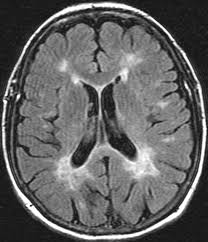

Denoised X-ray:


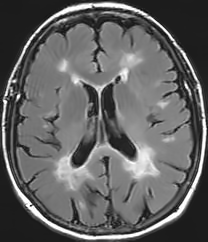

In [7]:
print("Original X-ray:")
cv2_imshow(xray)
print("Denoised X-ray:")
cv2_imshow(denoised)

In [7]:
cv2.imwrite('denoised_xray.jpg', denoised)
print("Saved 'denoised_xray.jpg' at original size - ready for the next step!")

Saved 'denoised_xray.jpg' at original size - ready for the next step!


Loaded denoised X-ray: (242, 208)
Resized to: (256, 256)
Denoised X-ray (original size):


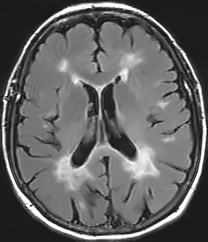

Resized to 256x256:


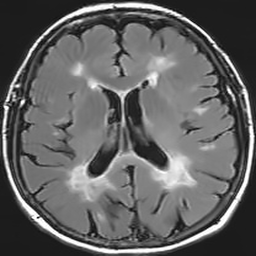

Saved 'resized_256.jpg' - ready for segmentation!


In [29]:
denoised = cv2.imread('denoised_xray.jpg', cv2.IMREAD_GRAYSCALE)
if denoised is None:
    print("Bruh, upload 'denoised_xray.jpg' first! Run the denoising step!")
else:
    print(f"Loaded denoised X-ray: {denoised.shape}")

# Step 4: Resize to 256x256 with Lanczos interpolation
target_res = 256
resized_256 = cv2.resize(denoised, (target_res, target_res), interpolation=cv2.INTER_LANCZOS4)
print(f"Resized to: {resized_256.shape}")

# Step 5: Show results
print("Denoised X-ray (original size):")
cv2_imshow(denoised)
print("Resized to 256x256:")
cv2_imshow(resized_256)

# Step 6: Save for next step
cv2.imwrite('resized_256.jpg', resized_256)
print("Saved 'resized_256.jpg' - ready for segmentation!")

In [39]:
!pip install torch torchvision albumentations

# Step 2: Import libraries
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from google.colab.patches import cv2_imshow

In [40]:
!mkdir -p /content/dataset/images /content/dataset/masks
import glob
import shutil

In [43]:
!unzip /content/archive.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_

In [44]:
data_dir = '/content/lgg-mri-segmentation/kaggle_3m'
for img_path in glob.glob(f'{data_dir}/**/*.tif', recursive=True):
    if '_mask' in img_path:
        shutil.copy(img_path, f'/content/dataset/masks/{os.path.basename(img_path).replace("_mask.tif", ".tif")}')
    else:
        shutil.copy(img_path, f'/content/dataset/images/{os.path.basename(img_path)}')

In [51]:
class BrainMRIDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('.tif', '_mask.tif'))

        image = cv2.imread(img_path, cv2.IMREAD_COLOR)  # 3-channel
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Check if mask file was loaded correctly
        if mask is None:
            print(f"Error: Mask file not found or corrupted: {mask_path}")
            # Handle the error, e.g., skip this sample or raise an exception
            return None  # or raise an exception

        image = image.astype(np.float32) / 255.0
        mask = (mask > 127).astype(np.float32)  # Binary: 0 or 1

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        image = image.transpose(2, 0, 1)  # HWC to CHW
        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).float().unsqueeze(0)

        return image, mask

In [48]:
image_dir = '/content/dataset/images'
mask_dir = '/content/dataset/masks'

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
])

dataset = BrainMRIDataset(image_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [49]:
model = torch.hub.load(
    'mateuszbuda/brain-segmentation-pytorch',
    'unet',
    in_channels=3,
    out_channels=1,
    init_features=32,
    pretrained=True,
    trust_repo=True
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [52]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 5  # Adjust based on dataset size
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.4f}")

# Step 8: Save the fine-tuned model
torch.save(model.state_dict(), '/content/finetuned_unet.pth')
print("Saved fine-tuned model as 'finetuned_unet.pth'!")

TypeError: '>' not supported between instances of 'NoneType' and 'int'